In [1]:
import wikipedia
import numpy as np
import os
import json
import requests
from random import sample
from typing import List, Callable, Dict, Iterable
from time import sleep

In [2]:
import re
import logging
from sys import stdout

In [3]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
logger = logging.getLogger(__name__)

logger.setLevel(logging.INFO)

handler = logging.StreamHandler(stdout)

logger.addHandler(handler)

# Задание 1


Выберите 5 языков в википедии (не тех, что использовались в семинаре). Скачайте по 10 случайных статей для каждого языка. Предобработайте тексты, удаляя лишние теги/отступы/разделители (если они есть). Разделите тексты на предложения и создайте датасет, в котором каждому предложению соответствует язык. Кластеризуйте тексты, используя эбмединг модель из прошлого семинара и любой алгоритм кластеризации. Проверьте качество кластеризации с помощь метрики ARI.

In [5]:
def choose_langs(n: int) -> List[tuple]:

    langs = wikipedia.languages()

    chosen_langs = sample(list(langs.items()), n)

    return chosen_langs

### Download texts

In [6]:
def load_with_disambigution(page: str) -> object:
    try:
        p = wikipedia.page(page)
    except wikipedia.DisambiguationError as e:
        random_option = np.random.choice(e.options)
        p = wikipedia.page(random_option)
    return p

In [7]:
from string import punctuation

def text_processing(text: str) -> List[str]:

    # уберем лишние знаки препинания и скобки со сносками/ссылками
    temp = re.sub("(?<=\s)\W(?=\s)", "", text)
    
    temp = re.sub(r"\(.*?\)|\[.+?\]", "", temp)

    # уберем переносы
    temp = re.sub(r"(\n)|(\t)", " ", temp)

    # делим по наиболее частотным знакам препинания (правда может возникнуть беда в случае иероглифических языков)
    temp = re.split(r"\. |\? |! |; |。", temp)
    
    return [sent for sent in temp if len(sent) > 4]

In [8]:
def get_texts_for_lang(lang: str, n: int = 100): # функция для скачивания статей из википедии
    # вот так можно зафиксировать язык
    wikipedia.set_lang(lang)
    wiki_content = []
    
    # random достает только ссылки на статьи
    pages = wikipedia.random(n)

    counter = 0
    
    while counter < n:

        logger.info(f"Lang: {lang}, page:{pages[counter]}, processed: {counter+1}")
        
        try:
            # чтобы загрузить контент статьи можно вызвать функцию .page
            page = load_with_disambigution(pages[counter])
        
        except Exception as e:
            print('Skipping page {}'.format(page), e)
            pages.append(wikipedia.random(1))
            continue

        else:
            wiki_content.append(f'{page.title}\n{page.content.replace("==", "")}')
            counter += 1

    return wiki_content

In [9]:
def download_texts(chosen_langs: List, download_count: int = 5, text_count: int = 10) -> Dict:
    
    wiki_texts = {}
    
    i = 0
    
    while i < len(chosen_langs):
    
        lang = chosen_langs[i][0]
        i += 1
        
        try:
            wiki_texts[lang] = get_texts_for_lang(lang, text_count)
    
            logger.info(f"Texts for lang: {lang} downloaded")
            download_count -= 1
        except Exception as e:
            logger.error(f'ERROR ON -  {lang}, {e}')
            chosen_langs.append(choose_langs(1)[0])
            continue
    
        if download_count == 0:
            break

    return wiki_texts

In [10]:
chosen_langs = choose_langs(5)


chosen_langs

[('ba', 'башҡортса'),
 ('olo', 'livvinkarjala'),
 ('bbc-latn', 'Batak Toba'),
 ('he', 'עברית'),
 ('tok', 'toki pona')]

In [11]:
wiki_texts = download_texts(chosen_langs)

Lang: ba, page:Пыдрейка, processed: 1
Lang: ba, page:Сырья, processed: 2
Lang: ba, page:Сәлмәнова Айһылыу Рафиҡ ҡыҙы, processed: 3
Lang: ba, page:Сигав-Игол, processed: 4
Lang: ba, page:Һауа, processed: 5
Lang: ba, page:Лысенина Августа Васильевна, processed: 6
Lang: ba, page:Рэй Брэдбери, processed: 7
Lang: ba, page:Диваев Рафаил Үзбәк улы, processed: 8
Lang: ba, page:Аннели Отт, processed: 9
Lang: ba, page:Яңы Ҡабан ауыл Советы (Краснокама районы), processed: 10
Texts for lang: ba downloaded
Lang: olo, page:Apel'siinu, processed: 1
Lang: olo, page:Iridii, processed: 2
Lang: olo, page:Prometii, processed: 3
Lang: olo, page:Uuzi Lohijärvi, processed: 4
Lang: olo, page:1959, processed: 5
Lang: olo, page:Akimisto, processed: 6
Lang: olo, page:Muljana, processed: 7
Lang: olo, page:Sportukižoin luvettelo, processed: 8
Lang: olo, page:4. kevätkuudu, processed: 9
Lang: olo, page:4. talvikuudu, processed: 10
Texts for lang: olo downloaded
ERROR ON -  bbc-latn, HTTPConnectionPool(host='bbc-lat

### Dataset ready for clusterization

In [12]:
data = [(lang, sent) for lang, texts in wiki_texts.items() for text in texts for sent in text_processing(text)]

In [13]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = "cpu")

2023-10-24 02:19:38.330306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Split into features and targets

In [14]:
target, sents = zip(*data)

### Generate embeddings

In [15]:
features = model.encode(sents)

In [16]:
len(features)

640

In [17]:
len(sents)

640

### clusterization approaches

In [18]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.cluster import AgglomerativeClustering, DBSCAN, AffinityPropagation, KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [19]:
import numpy as np

In [20]:
import matplotlib.pyplot as plt

In [21]:
target = np.array(target)

In [22]:
n_clusters = len(np.unique(target))

In [23]:
enc = LabelEncoder()

y_test = enc.fit_transform(target.reshape(-1))

### Use DBSCAN

In [24]:
np.linspace(0.5, 1.5, 5)

array([0.5 , 0.75, 1.  , 1.25, 1.5 ])

In [25]:
params = {"eps" : np.linspace(0.05, 0.8, 10),
         "min_samples": np.arange(3, 10)}

max_score = (-0.5, -1, -1)

for i in params["eps"]:
    for j in params["min_samples"]:

        dbscan = DBSCAN(eps = i, min_samples=j)

        dbscan.fit(features)

        ari = adjusted_rand_score(y_test, dbscan.labels_)
            
        logger.debug(f"Adjusted rand score is {round(ari, 4)} with min_samples= {j} and eps= {round(i, 4)} ")

        if ari > max_score[0]:
            max_score = (ari, i, j)

logger.info(f"Max score: {round(max_score[0], 4)}, with min_samples= {max_score[2]} and eps= {round(max_score[1], 4)} ")

Max score: 0.7879, with min_samples= 8 and eps= 0.8 


### AgglomerativeClustering

In [26]:
params = {"n_clusters": np.arange(2, 6)}

max_score = (-1, 0)

for param in params["n_clusters"]:
    
    aglcl = AgglomerativeClustering(metric = "cosine", n_clusters= param,
                                   linkage="complete")
    
    aglcl.fit(features)
    
    ari = adjusted_rand_score(y_test, aglcl.labels_)
    
    logger.debug(f"Adjusted rand score is {round(ari, 4)} with n_clusters= {param}")

    if ari > max_score[0]:
        max_score = (ari, param)


if max_score[0] == 0:
    logger.warning("Fail!")
else:
    logger.info(f"Max score: {round(max_score[0], 4)}, with n_clusters= \
    {max_score[1]} ")

Max score: 0.9384, with n_clusters=     5 


# Задание 2

Загрузите корпус `annot.opcorpora.no_ambig_strict.xml.bz2` с OpenCorpora. Найдите в корпусе самые частотные морфологически омонимичные словоформы (те, которым соответствует разный грамматический разбор). Также найдите словоформы с самых большим количеством вариантов грамматических разборов.

In [27]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [28]:
!wget -O data/opencorpora.xml.bz2 https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2

--2023-10-24 02:20:10--  https://opencorpora.org/files/export/annot/annot.opcorpora.no_ambig_strict.xml.bz2
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving opencorpora.org (opencorpora.org)... 104.21.15.199, 172.67.163.210, 2606:4700:3031::ac43:a3d2, ...
Connecting to opencorpora.org (opencorpora.org)|104.21.15.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1435269 (1.4M) [application/x-bzip2]
Saving to: ‘data/opencorpora.xml.bz2’

data/opencorpora.xm 100%[===================>]   1.37M  6.25MB/s    in 0.2s    

2023-10-24 02:20:10 (6.25 MB/s) - ‘data/opencorpora.xml.bz2’ saved [1435269/1435269]



In [29]:
import bz2

with bz2.open('data/opencorpora.xml.bz2', 'rb') as f_in, open('data/annot.opcorpora.no_ambig_strict.xml', 'wb') as f_out:
    f_out.write(f_in.read())

In [30]:
! rm data/opencorpora.xml.bz2

In [31]:
! head -n 100 data/annot.opcorpora.no_ambig_strict.xml

<?xml version="1.0" encoding="utf-8" standalone="yes"?>
<annotation version="0.12" revision="4580223">
<text id="1" parent="0" name="&quot;Частный корреспондент&quot;">
  <tags>
    <tag>url:http://www.chaskor.ru</tag>
    <tag>Тип:Газета</tag>
  </tags>
  <paragraphs>
  </paragraphs>
</text>
<text id="2" parent="1" name="00021 Школа злословия">
  <tags>
    <tag>Год:2008</tag>
    <tag>Дата:25/08</tag>
    <tag>Автор:Валентин Колесников</tag>
    <tag>url:http://www.chaskor.ru/article/shkola_zlosloviya_uchit_prikusit_yazyk_21</tag>
    <tag>Тема:ЧасКор:Медиа</tag>
    <tag>Тема:ЧасКор:Медиа/ТВ и радио</tag>
  </tags>
  <paragraphs>
    <paragraph id="1">
      <sentence id="1">
        <source>«Школа злословия» учит прикусить язык</source>
        <tokens>
          <token id="1" text="«"><tfr rev_id="2420236" t="«"><v><l id="0" t="«"><g v="PNCT"/></l></v></tfr></token>
          <token id="2" text="Школа"><tfr rev_id="834910" t="Школа"><v><l id="380220" t="школа"><g v="NOUN"/><g v="i

In [32]:
from lxml import etree
from pymorphy3 import MorphAnalyzer
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter

In [33]:
open_corpora = etree.fromstring(open('data/annot.opcorpora.no_ambig_strict.xml', 'rb').read())

In [34]:
corpus = []


for sentence in open_corpora.xpath('//tokens'):
    sent_tagged = []
    for token in sentence.xpath('token'):
        word = token.xpath('@text')
        gram_info = token.xpath('tfr/v/l/g/@v')
        sent_tagged.append([word[0].lower()] + gram_info)
    
    corpus.append(sent_tagged)
        

### Get most common homoforms

найдем слова с наибольщим количеством омоформ (т.е. имеющих одно и то же написание, но разный грамматический разбор)

In [35]:
def most_common_homoforms(corpus: List, n_count: int) -> List[tuple]:
    
    homoforms_c = Counter()
    
    form_set = set()
    
    for i in range(len(corpus)):
        for j in range(len(corpus[i])):
    
            temp = tuple(corpus[i][j])
        
            if temp in form_set:
                continue
    
            form_set.add(temp)
        
            homoforms_c.update([temp[0]])

    return homoforms_c.most_common(n_count)

In [36]:
most_common_homoforms(corpus, 10)

[('сша', 6),
 ('кино', 5),
 ('евро', 5),
 ('компании', 5),
 ('пути', 5),
 ('какой', 5),
 ('это', 4),
 ('одной', 4),
 ('своей', 4),
 ('лица', 4)]

вообще логический анализ подсказывает, что либо я не так понял формулировку вопроса, либо они явно эквивалентны, потому как наиболее частотные омонимы и слова с наибольшим числом различных грамматических разборов как будто бы имеют один и тот же набор референтов

In [37]:
from collections import defaultdict

def most_divirse_grammar(corpus: List, n_count: int) -> List[tuple]:

    words = defaultdict(set)

    grammar_c = Counter()

    for i in range(len(corpus)):
        for j in range(len(corpus[i])):
    
            temp = tuple(corpus[i][j])

            if temp[1:] in words[temp[0]]:
                continue
            
            grammar_c.update([temp[0]])
            words[temp[0]].add(temp[1:])

    return grammar_c.most_common(n_count)


In [38]:
most_divirse_grammar(corpus, 10)

[('сша', 6),
 ('кино', 5),
 ('евро', 5),
 ('компании', 5),
 ('пути', 5),
 ('какой', 5),
 ('это', 4),
 ('одной', 4),
 ('своей', 4),
 ('лица', 4)]

идентичность результатов алгоритмов как бы это доказывает

## Задание 3
Загрузите один и з файлов корпуса Syntagrus - https://github.com/UniversalDependencies/UD_Russian-SynTagRus/tree/master (можно взять тестовый)

Преобразуйте все разборы предложений в графовые структуру через DependencyGraph, выберите отношение (из тех, что не упоминались на семинаре) и найдите самые частотные пары слов, связанных этим отношением. 

Для самой частотной пары вытащите все подзависимые слова для каждого из них во всех предложениях (используя `flatten(get_subtree(d.nodes, index_of_a_word)`) В итоге у вас должен получится список пары: слово1 и все его подзависимые - слово2 и все его подзависимые.

Визуализируйте самое длинное предложение через networkx

In [39]:
! wget -O data/syntagrus-ud.conllu https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu

--2023-10-24 02:20:14--  https://raw.githubusercontent.com/UniversalDependencies/UD_Russian-SynTagRus/master/ru_syntagrus-ud-test.conllu
Loaded CA certificate '/etc/ssl/certs/ca-certificates.crt'
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14970950 (14M) [text/plain]
Saving to: ‘data/syntagrus-ud.conllu’

data/syntagrus-ud.c 100%[===================>]  14.28M  15.4MB/s    in 0.9s    

2023-10-24 02:20:16 (15.4 MB/s) - ‘data/syntagrus-ud.conllu’ saved [14970950/14970950]



In [40]:
from nltk import DependencyGraph
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

In [41]:
def load_trees(filename: str) -> List:

    trees = []
    
    with open(filename, "r") as f:
        sents = f.read().split("\n\n")
        
    for sent in sents:

        tree = [line.replace("\t", " ") for line in sent.split("\n") if not \
                line.startswith("#")]

        trees.append(tree)
        

    return trees

In [42]:
def flatten(l: Iterable) -> List:
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat

In [43]:
def get_subtree(nodes: List, node: int) -> List:
    
    
    if not nodes[node]['deps']:
        return [node]
    
    else:
        return [node] + [get_subtree(nodes, dep) for rel in nodes[node]['deps'] 
                         if rel != 'punct'  # пунктуацию доставать не будем
                         for dep in nodes[node]['deps'][rel]]



In [44]:
def build_dgraps(trees: List) -> List[DependencyGraph]: 
    
    d_graphs = []
    i = 0
    
    for tree in trees:
        
        try:
            dep = DependencyGraph(tree)
        except Exception as e:
            logger.error(f"Error {e.with_traceback} occured on element {i}")
            
        dep.root = dep.nodes[0]
    
        d_graphs.append(dep)
    
        i +=1

    return d_graphs

In [45]:
trees = load_trees("data/syntagrus-ud.conllu")

In [46]:
d_graphs = build_dgraps(trees)

Error <built-in method with_traceback of AssertionError object at 0x7fe1386297e0> occured on element 725
Error <built-in method with_traceback of AssertionError object at 0x7fe1386d2ce0> occured on element 752
Error <built-in method with_traceback of AssertionError object at 0x7fe1385ce980> occured on element 818
Error <built-in method with_traceback of AssertionError object at 0x7fdfe3ed7fa0> occured on element 1470


/home/xenos/Documents/masters/venv/lib/python3.11/site-packages/nltk/parse/dependencygraph.py:376: UserWarning: The graph doesn't contain a node that depends on the root element.
  warnings.warn(


### Find most common pairs for "ADVMOD"

In [48]:
def common_pairs_for_relation(d_graphs: List[DependencyGraph], 
                              relation: str, n: int) -> Counter:
    
    pairwise = Counter()
    
    for graph in d_graphs:
    
        triples = list(graph.triples())
    
        for el1, rel, el2 in triples:
            if rel == relation:
                pairwise[(el1[0], el2[0])] += 1

    return pairwise.most_common(n)

In [51]:
def get_deps_for_words(words: Iterable, d_graphs: List[DependencyGraph]) -> defaultdict:
    
    deps = defaultdict(set)
    
    for word in target:
        for graph in d_graphs:
    
            for node_i, node in graph.nodes.items():
    
                if node["word"] == word:
    
                    deps[word].update(graph.nodes[i]["word"] for i in \
                        flatten(
                            get_subtree(graph.nodes, node_i)
                        )
                    )

    return deps

In [49]:
common_pairs_for_relation(d_graphs, "advmod", 5)

[(('только', 'не'), 65),
 (('было', 'не'), 40),
 (('может', 'не'), 24),
 (('так', 'не'), 22),
 (('то', 'же'), 22)]

In [50]:
target = common_pairs_for_relation(d_graphs, "advmod", 1)[0][0]

In [52]:
deps = get_deps_for_words(target, d_graphs)

In [53]:
deps

defaultdict(set,
            {'только': {'Вот',
              'Не',
              'и',
              'не',
              'пока',
              'столько',
              'только',
              'что'},
             'не': {'А',
              'Даже',
              'Далеко',
              'Ничуть',
              'Ну',
              'Потому',
              'Практически',
              'Тем',
              'Трампа',
              'более',
              'больше',
              'было',
              'в',
              'вовсе',
              'вообще',
              'высказываний',
              'гонять',
              'даже',
              'далеко',
              'два',
              'делать',
              'едва',
              'заведомо',
              'ибо',
              'информационной',
              'истине',
              'как',
              'кем',
              'коем',
              'кстати',
              'ли',
              'не',
              'ни',
              'никак',
           

### Visualize longest sentence

In [55]:
longest_sent = max(d_graphs, key = lambda x: len(x.nodes))

In [63]:
" ".join(word for word in longest_sent.nx_labels.values())

'Несмотря на то , что из-за серьезных ограничений регламента скорости в Формуле - 1 не самые высокие в автогонках и уступают , например , серии Champ Car ( так , в этой серии рекорд максимальной скорости был поставлен Жилем де Ферраном на квалификации к последней гонке сезона 2000 г. Мальборо 500 на треке в Фонтане , когда он прошел круг со средней скоростью 388 км/ч , а максимальная моментальная скорость , по некоторым сведениям , была достигнута Полом Трейси в 1996 г. на треке в Мичигане , когда он разогнался до 413 км/ч во время одной из практик , - эти показатели самые быстрые из когда-либо достигнутых в кольцевых автогонках ) , конкуренция между командами способствует повышению технического уровня по другим направлениям .'

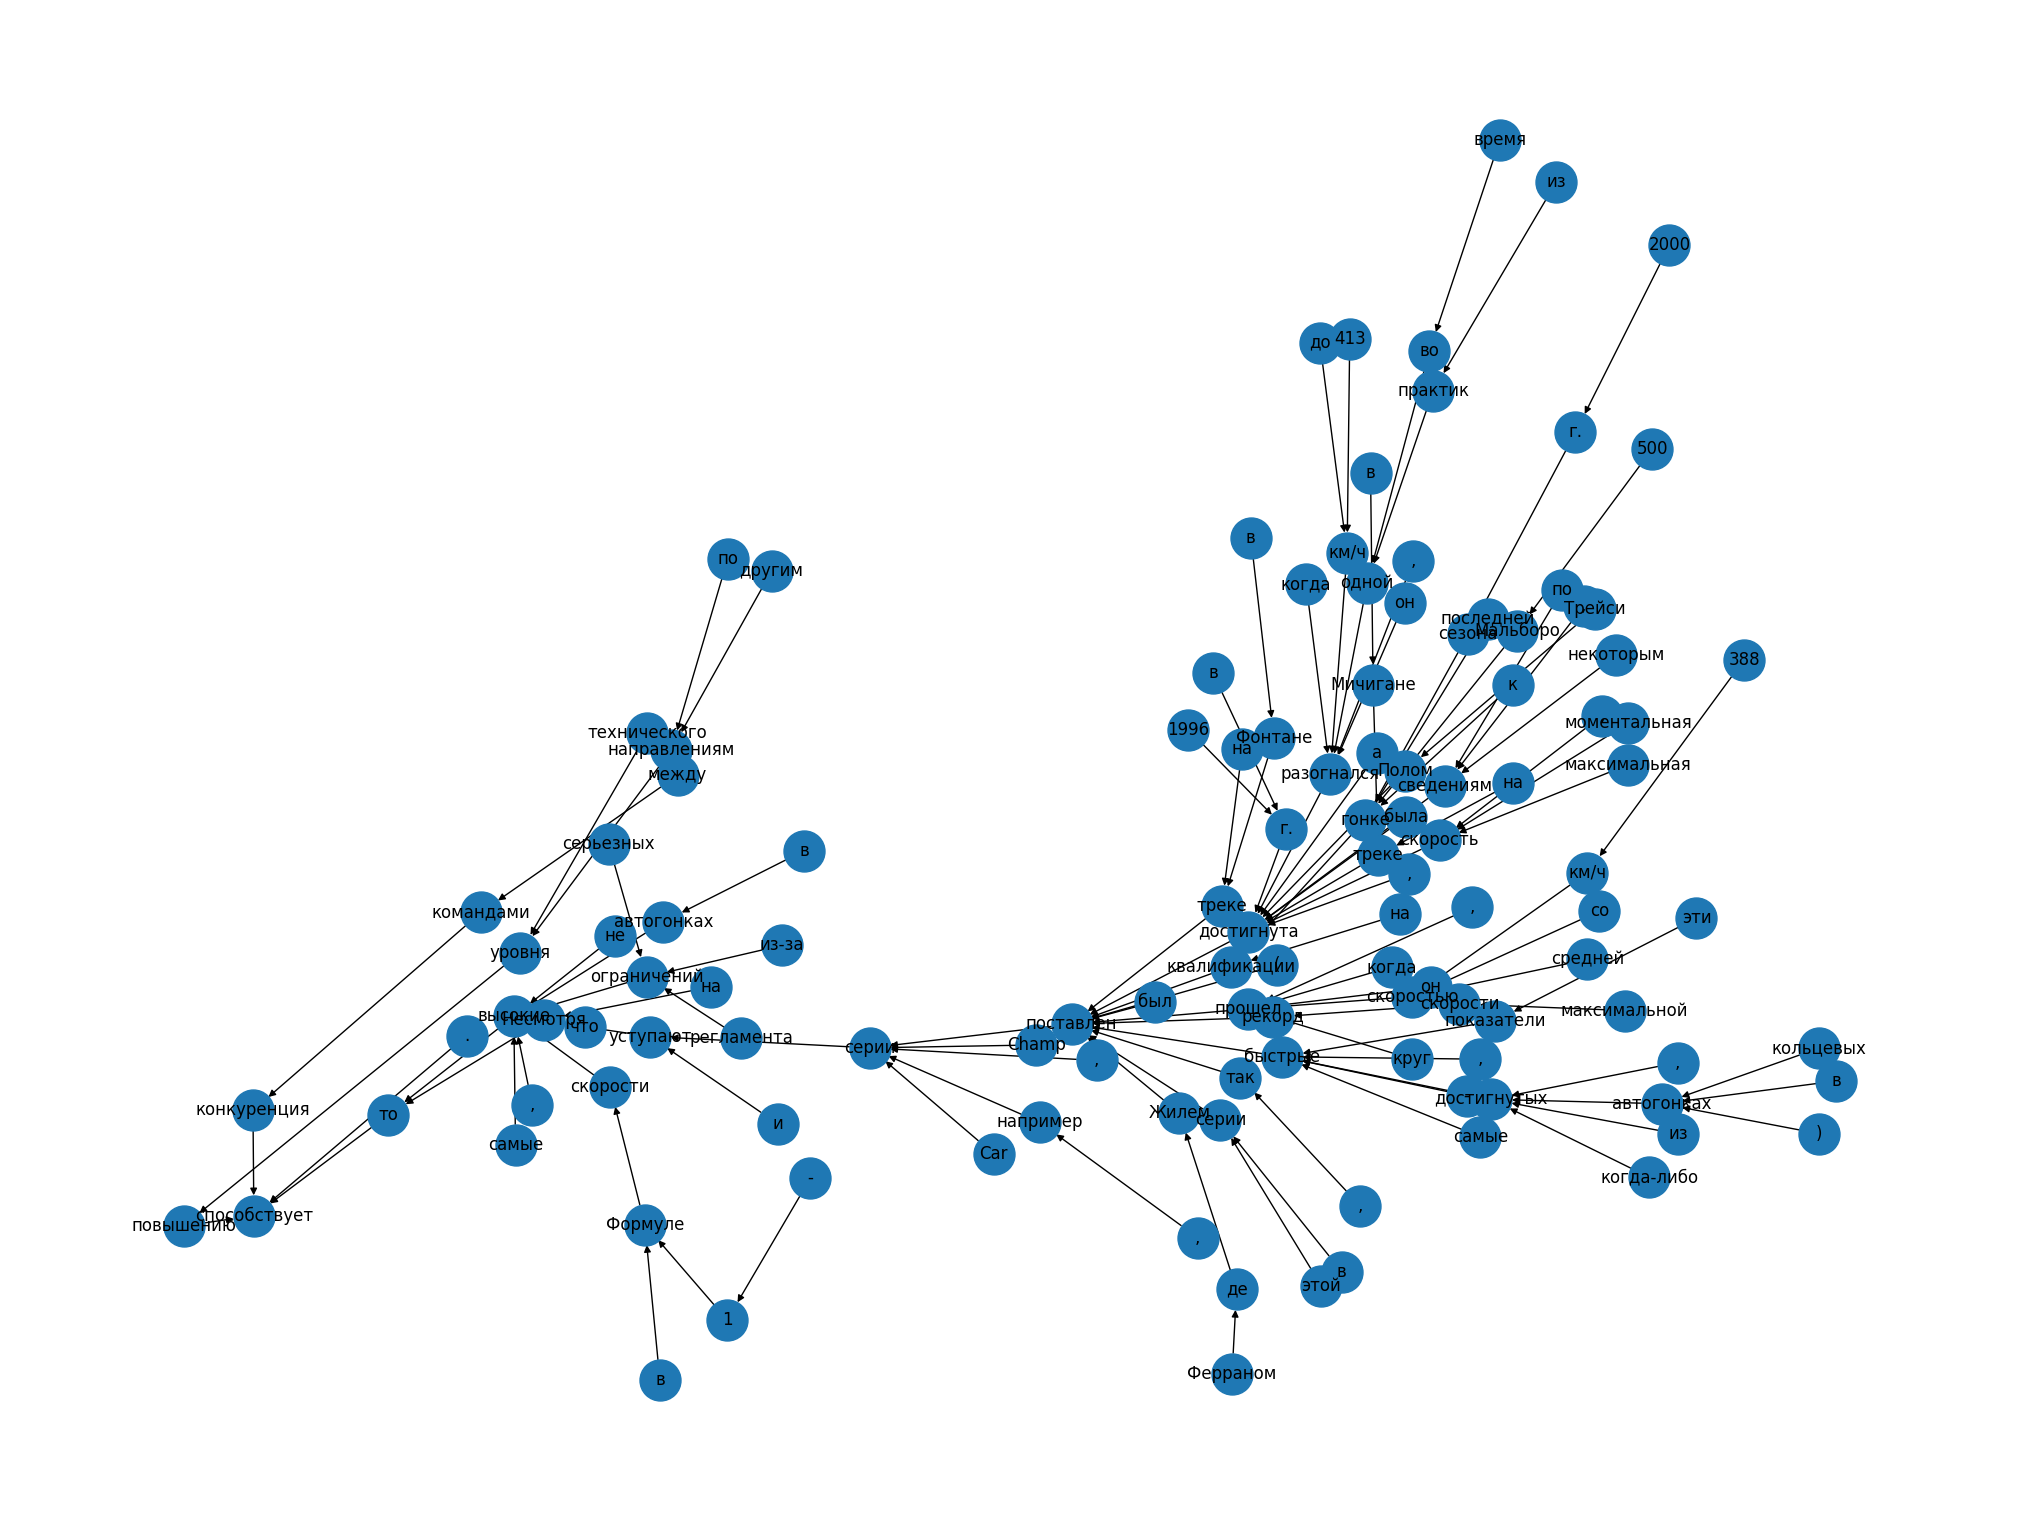

In [64]:
plt.figure(figsize = (20, 15))
nx.draw(longest_sent.nx_graph(), labels = longest_sent.nx_labels, node_size = 870)